In [1]:
%load_ext tensorboard
!rm -rf ./logs/

'rm' 不是內部或外部命令、可執行的程式或批次檔。


In [2]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint
from ray import tune
from ray.tune import CLIReporter
from ray import tune
from ray import train
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection
from darts.dataprocessing.transformers import Scaler
from darts.models import NHiTSModel
from darts import TimeSeries, concatenate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import tensorboard
import os

In [3]:
class LossLoggingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.val_losses = []  # To store validation losses
        self.train_losses = []  # To store training losses

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics["val_loss"].item()
        self.val_losses.append(val_loss)
        print(f"Epoch {trainer.current_epoch}: val_loss={val_loss}")
        train.report({"loss": val_loss})

    def on_train_epoch_end(self, trainer, pl_module, unused=None):  # unused parameter for compatibility
        # Assuming you have a metric named "train_loss" logged
        if "train_loss" in trainer.callback_metrics:
            train_loss = trainer.callback_metrics["train_loss"].item()
            self.train_losses.append(train_loss)
            print(f"Epoch {trainer.current_epoch}: train_loss={train_loss}")

In [51]:
# 步骤1: 加载CSV文件
df = pd.read_csv('EDvisitfile.csv')

# 确保'date'列是DateTime类型
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 分割数据集为训练集、验证集和测试集（假设您已经根据时间排序）
#train_proportion = 0.5
#val_proportion = 0.3

# Calculate the split indices
total_length = len(df)
train_end = 4742
val_end = 5107
#val_end = train_end + int(total_length * val_proportion)

# Split the DataFrame
train_df = df.iloc[1461:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# 步骤2: 使用MinMaxScaler缩放数据
# 定义并拟合scaler
scaler = MinMaxScaler()
scaler.fit(train_df[['No']])  # 只用训练数据拟合scaler

# 缩放训练集和验证集
train_df.loc[:, 'No_scaled'] = scaler.transform(train_df[['No']])
val_df.loc[:, 'No_scaled'] = scaler.transform(val_df[['No']])
test_df.loc[:, 'No_scaled'] = scaler.transform(test_df[['No']])  # 用相同的scaler转换测试集以避免数据泄露

train_series = TimeSeries.from_dataframe(train_df, value_cols='No_scaled' )
val_series = TimeSeries.from_dataframe(val_df, value_cols='No_scaled' )
test_series = TimeSeries.from_dataframe(test_df, value_cols='No_scaled' )

# 原始数据转换为TimeSeries对象，如果需要
train_series_origin = TimeSeries.from_dataframe(train_df, value_cols='No'  )
val_series_origin = TimeSeries.from_dataframe(val_df, value_cols='No' )
test_series_origin = TimeSeries.from_dataframe(test_df, value_cols='No' )

# 选择需要的列创建多变量时间序列(都是one hot coding)
columns = ['Dayoff', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun',  'YearScaled', 'MonthScaled', 'Dayscaled', 'NewYear', '3Lock']
df_multivariate = df[columns]

# 将DataFrame转换为多变量时间序列
ED_covariates = TimeSeries.from_dataframe(df_multivariate )

C:\Users\ian11\AppData\Local\Temp\ipykernel_12972\1089142995.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'No_scaled'] = scaler.transform(train_df[['No']])
C:\Users\ian11\AppData\Local\Temp\ipykernel_12972\1089142995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[:, 'No_scaled'] = scaler.transform(val_df[['No']])
C:\Users\ian11\AppData\Local\Temp\ipykernel_12972\1089142995.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\ian11\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory C:\darts_logs\_model.pth.tar exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 239 K 
---------------------------------------------------
229 K     Trainable params
9.6 K     Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0: val_loss=0.03938113624583631


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: val_loss=0.007525207166433682
Epoch 0: train_loss=0.005267764534689092


Validation: 0it [00:00, ?it/s]

Epoch 1: val_loss=0.0069858740921145196
Epoch 1: train_loss=0.006522145774125544


Validation: 0it [00:00, ?it/s]

Epoch 2: val_loss=0.007178839827044105
Epoch 2: train_loss=0.006266487885384535


Validation: 0it [00:00, ?it/s]

Epoch 3: val_loss=0.007481560929780495
Epoch 3: train_loss=0.004258429309734877


Validation: 0it [00:00, ?it/s]

Epoch 4: val_loss=0.007971177840359318
Epoch 4: train_loss=0.011387382387449132


Validation: 0it [00:00, ?it/s]

Epoch 5: val_loss=0.0063789382949186865
Epoch 5: train_loss=0.006343294185152512


Validation: 0it [00:00, ?it/s]

Epoch 6: val_loss=0.006402517660715059
Epoch 6: train_loss=0.005859194783503807


Validation: 0it [00:00, ?it/s]

Epoch 7: val_loss=0.006144422676449316
Epoch 7: train_loss=0.006056631310291523


Validation: 0it [00:00, ?it/s]

Epoch 8: val_loss=0.0061880768463759735
Epoch 8: train_loss=0.00628181553296163


Validation: 0it [00:00, ?it/s]

Epoch 9: val_loss=0.005722941000332508
Epoch 9: train_loss=0.004129078763298213


Validation: 0it [00:00, ?it/s]

Epoch 10: val_loss=0.006420734867196157
Epoch 10: train_loss=0.00457267613774683


Validation: 0it [00:00, ?it/s]

Epoch 11: val_loss=0.006180023837584325
Epoch 11: train_loss=0.004354912962610414


Validation: 0it [00:00, ?it/s]

Epoch 12: val_loss=0.00759794280237242
Epoch 12: train_loss=0.0053660221609379164


Validation: 0it [00:00, ?it/s]

Epoch 13: val_loss=0.00640007408089927
Epoch 13: train_loss=0.0037400588865104346


Validation: 0it [00:00, ?it/s]

Epoch 14: val_loss=0.005667143922857461
Epoch 14: train_loss=0.0031288773065324595


Validation: 0it [00:00, ?it/s]

Epoch 15: val_loss=0.006805915015443401
Epoch 15: train_loss=0.0057681726145171214


Validation: 0it [00:00, ?it/s]

Epoch 16: val_loss=0.006023864361509198
Epoch 16: train_loss=0.0036708048124286397


Validation: 0it [00:00, ?it/s]

Epoch 17: val_loss=0.006366782270276893
Epoch 17: train_loss=0.003514772060118654


Validation: 0it [00:00, ?it/s]

Epoch 18: val_loss=0.006058496307768667
Epoch 18: train_loss=0.007408349441486945


Validation: 0it [00:00, ?it/s]

Epoch 19: val_loss=0.006501137315320199
Epoch 19: train_loss=0.0031925077831055702


Validation: 0it [00:00, ?it/s]

Epoch 20: val_loss=0.0066234526665152095
Epoch 20: train_loss=0.004957086238019015


Validation: 0it [00:00, ?it/s]

Epoch 21: val_loss=0.006040412484373381
Epoch 21: train_loss=0.004304106743740305


Validation: 0it [00:00, ?it/s]

Epoch 22: val_loss=0.007224040178189791
Epoch 22: train_loss=0.0029295920389699483


Validation: 0it [00:00, ?it/s]

Epoch 23: val_loss=0.006983044200677275
Epoch 23: train_loss=0.005326741499110389


Validation: 0it [00:00, ?it/s]

Epoch 24: val_loss=0.006209192703655237
Epoch 24: train_loss=0.0029710749438071563


Validation: 0it [00:00, ?it/s]

Epoch 25: val_loss=0.006733582181841267
Epoch 25: train_loss=0.004221507393928212


Validation: 0it [00:00, ?it/s]

Epoch 26: val_loss=0.006593641477045767
Epoch 26: train_loss=0.003125176559866945


Validation: 0it [00:00, ?it/s]

Epoch 27: val_loss=0.006127843637136045
Epoch 27: train_loss=0.007714108985290232


Validation: 0it [00:00, ?it/s]

Epoch 28: val_loss=0.005772166772325699
Epoch 28: train_loss=0.0031267192664776676


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: val_loss=0.007016839792364202
Epoch 29: train_loss=0.0035213602852628453


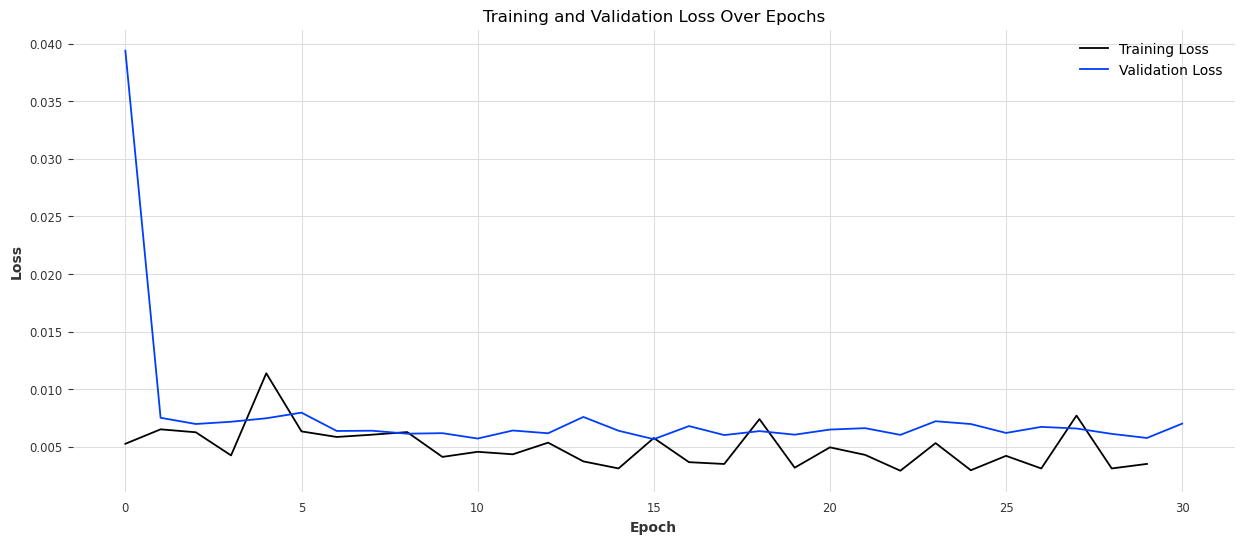

In [38]:
loss_logging_callback = LossLoggingCallback()

checkpoint_callback = ModelCheckpoint(
    filename='_model_{epoch:02d}',
    monitor='val_loss',
    save_top_k=-1,
    every_n_epochs=5,
    dirpath='/darts_logs/_model.pth.tar'# Save every 5 epochs
)

torch_metrics = MetricCollection([MeanAbsolutePercentageError(), MeanAbsoluteError()])

model = NHiTSModel(
    input_chunk_length=7, 
    output_chunk_length=7, 
    batch_size=64,
    num_stacks=1, 
    num_blocks=2, 
    num_layers=2, 
    layer_widths=300, 
    dropout=0.1, 
    activation='ReLU', 
    MaxPool1d=True,
    model_name="NHiTSFine2018(20)",
    lr_scheduler_kwargs=0.0001,
    save_checkpoints=True,
    pl_trainer_kwargs = {
    "callbacks": [loss_logging_callback, checkpoint_callback]},)

# After defining the model, proceed with the training as before
models = {
    "NHiTSModel": model,
}

model.fit(
    epochs=30,
    series=[train_series],
    past_covariates=[ED_covariates],
    val_series=[val_series],
    val_past_covariates=[ED_covariates]
    #past_covariates=[WeekdayTrain, DayoffTrain]
    #enable_checkpointing=True,
)

# Step 3: Plotting the losses after training is completed
plt.figure(figsize=(15, 6))

# Plot training losses
plt.plot(loss_logging_callback.train_losses, label="Training Loss")

# Plot validation losses
plt.plot(loss_logging_callback.val_losses, label="Validation Loss")

plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
from darts.metrics import mae, mse, mape
import matplotlib.pyplot as plt

In [52]:
model = NHiTSModel.load_from_checkpoint('NHiTSFine2018(20)')

hyperparameters = model.model_params
print(hyperparameters)
#model_loaded = model.load_weights('darts_logs/NHiTSFine2019(50)/checkpoints/last-epoch=49', load_encoders=False, skip_checks=True)
Model_prediction = model.predict(731, series=train_series, past_covariates=ED_covariates
                                )
# invert scale, 資料格式轉換
Model_prediction_df = Model_prediction.pd_dataframe()
Model_prediction_df_inverse = scaler.inverse_transform(Model_prediction_df)
Model_prediction_df_inverse = pd.DataFrame(Model_prediction_df_inverse,
                      index=Model_prediction_df.index,
                      columns=Model_prediction_df.columns)

# 計算誤差
Model_prediction_ts_inverse = TimeSeries.from_dataframe(Model_prediction_df_inverse)
Model_mae = mae(test_series_origin, Model_prediction_ts_inverse)
Model_mse = mse(test_series_origin, Model_prediction_ts_inverse)
Model_mape = mape(test_series_origin, Model_prediction_ts_inverse)

print(Model_mae, Model_mse, Model_mape)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


OrderedDict([('num_stacks', 1), ('num_blocks', 2), ('num_layers', 2), ('layer_widths', 300), ('pooling_kernel_sizes', None), ('n_freq_downsample', None), ('dropout', 0.1), ('activation', 'ReLU'), ('MaxPool1d', True), ('input_chunk_length', 7), ('output_chunk_length', 7), ('batch_size', 64), ('model_name', 'NHiTSFine2018(20)'), ('lr_scheduler_kwargs', 0.0001), ('save_checkpoints', True), ('pl_trainer_kwargs', {'callbacks': [<__main__.LossLoggingCallback object at 0x0000023E22E29150>, <pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x0000023E22E2B990>]})])


Predicting: 0it [00:00, ?it/s]

124.09594807705301 19508.431728276617 25.991113298065482


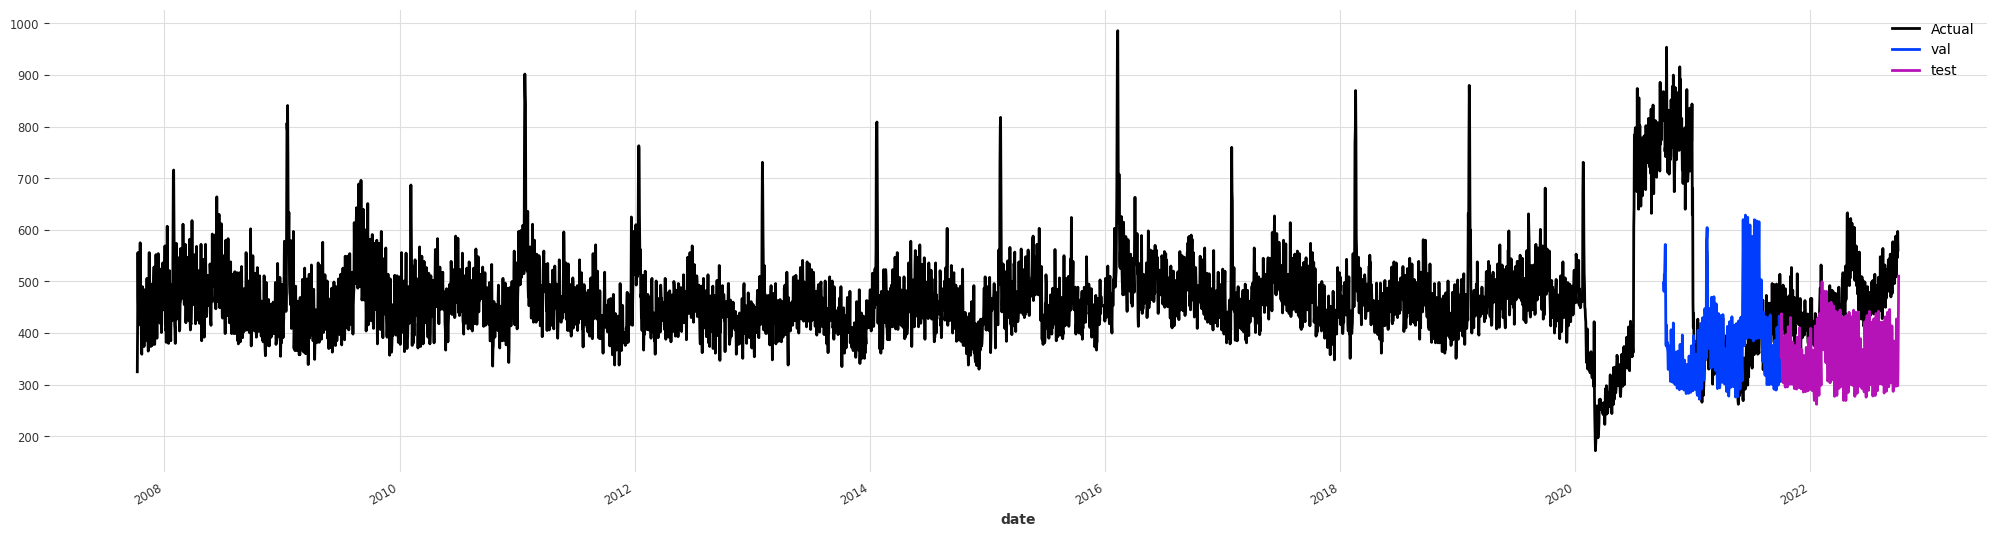

In [53]:
series_origin_complete = TimeSeries.from_dataframe(df, value_cols=['No'])

Model_prediction_ts_inverse_val, Model_prediction_ts_inverse_test = Model_prediction_ts_inverse.split_before(0.5)

# 绘制图表
plt.figure(figsize=(25, 6))
series_origin_complete.plot(label='Actual')

# 使用之前转换和逆缩放后的预测结果
Model_prediction_ts_inverse_val.plot(label='val')
Model_prediction_ts_inverse_test.plot(label='test')

plt.legend()
plt.show()